# Installing Dependencies

In [3]:
!pip install transformers -q

from IPython.display import clear_output
clear_output()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [34]:
import os
import tensorflow as tf
from tensorflow.keras import backend
import matplotlib.pyplot as plt
import cv2

In [6]:
%cd /content/drive/MyDrive/Billboard_Segmentation

/content/drive/MyDrive/Billboard_Segmentation


# Dataset

## Function to read the image file

In [7]:
def load_image_file(image_path, mask_path):
    image = tf.io.read_file(image_path)
    mask = tf.io.read_file(mask_path)

    image = tf.image.decode_png(image, channels=3)
    mask = tf.image.decode_png(mask, channels=1)

    return {"image": image, "segmentation_mask": mask}

In [8]:
train_image_dir = "Dataset/Train/images"
train_mask_dir = "Dataset/Train/masks"

valid_image_dir = "Dataset/Validation/images"
valid_mask_dir = "Dataset/Validation/masks"

In [9]:
#Define list of image and mask file names
train_image_names = sorted(os.listdir(train_image_dir))
train_mask_names = sorted(os.listdir(train_mask_dir))

valid_image_names = sorted(os.listdir(valid_image_dir))
valid_mask_names = sorted(os.listdir(valid_mask_dir))


print(f"Train_images : {len(train_image_names)}, Validation images : {len(valid_image_names)}")

Train_images : 594, Validation images : 10


In [10]:

train_pairs = []
for img_name in train_image_names:
    # Check if image file name matches mask file name
    mask_name = img_name.replace("image", "mask")
    if mask_name in train_mask_names:
      train_pairs.append((os.path.join(train_image_dir, img_name), os.path.join(train_mask_dir, mask_name)))

valid_pairs = []
for img_name in valid_image_names:
    # Check if image file name matches mask file name
    mask_name = img_name.replace("image", "mask")
    if mask_name in valid_mask_names:
        valid_pairs.append((os.path.join(valid_image_dir, img_name), os.path.join(valid_mask_dir, mask_name)))

In [11]:
# Load image and mask data from file paths
data_train = [load_image_file(image_path, mask_path) for image_path, mask_path in train_pairs]
data_valid = [load_image_file(image_path, mask_path) for image_path, mask_path in valid_pairs]

In [12]:
print(f"Train_Data : {len(data_train)}, Valid_Data : {len(data_valid)}")

Train_Data : 594, Valid_Data : 10


# Normalization and Image Resizing

In [13]:
image_size = 512
mean = tf.constant([0.485, 0.456, 0.406])
std = tf.constant([0.229, 0.224, 0.225])


def normalize(input_image, input_mask):
    input_image = tf.image.convert_image_dtype(input_image, tf.float32)
    input_image = (input_image - mean) / tf.maximum(std, backend.epsilon())
    input_mask = input_mask / 255
    return input_image, input_mask


def load_image(datapoint):
    input_image = tf.image.resize(datapoint["image"], (image_size, image_size))
    input_mask = tf.image.resize(
        datapoint["segmentation_mask"],
        (image_size, image_size),
        method="bilinear",
    )
    input_image, input_mask = normalize(input_image, input_mask)
    input_image = tf.transpose(input_image, (2, 0, 1))

    return {"pixel_values": input_image, "labels": tf.squeeze(input_mask)}

In [14]:
train_data = [load_image(datapoint) for datapoint in data_train]
valid_data = [load_image(datapoint) for datapoint in data_valid]

In [15]:
print(f"Normalize Train Data : {len(train_data)}, Normalize Validation Data : {len(valid_data)}")

Normalize Train Data : 594, Normalize Validation Data : 10


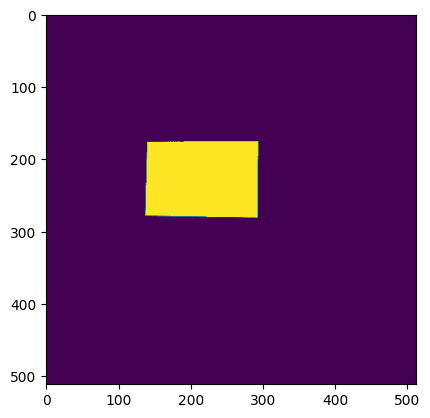

In [16]:
plt.imshow(train_data[27]["labels"]);

In [17]:
def generator_train():
    for datapoint in train_data:
        yield datapoint

def generator_valid():
    for datapoint in valid_data:
        yield datapoint


### Using <code>tf.data.Dataset</code> to build input pipeline

In [18]:
batch_size = 8
auto = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_generator(generator_train, output_types={"pixel_values": tf.float32, "labels": tf.int32}).cache().shuffle(batch_size * 10).batch(batch_size).prefetch(auto)

valid_ds = tf.data.Dataset.from_generator(generator_valid, output_types={"pixel_values": tf.float32, "labels": tf.int32}).batch(batch_size).prefetch(auto)



# Visualizing the data

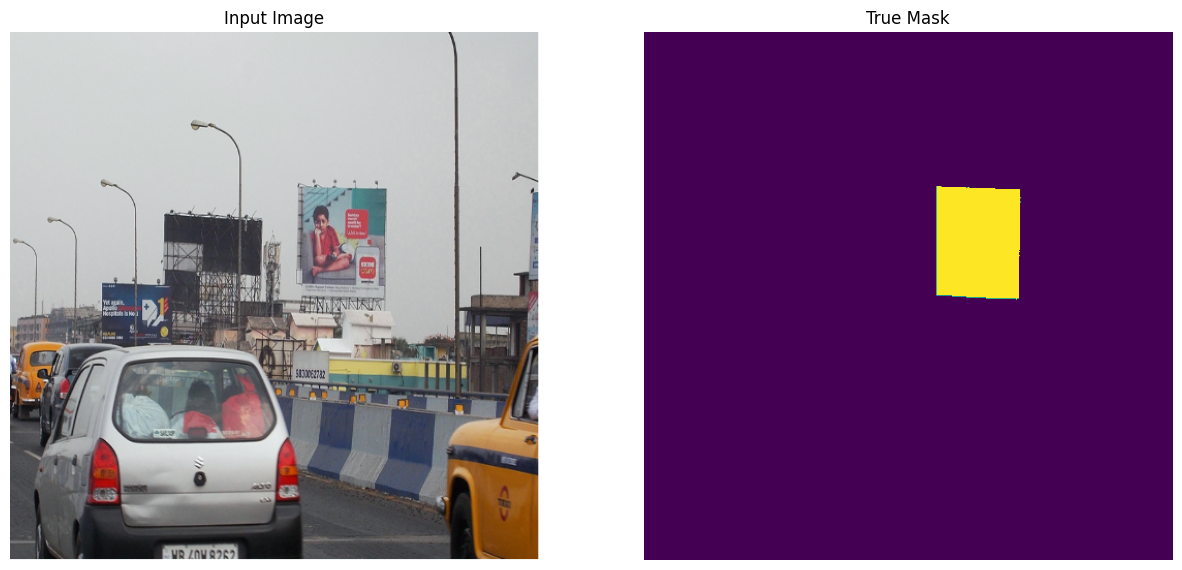

(512, 512, 3)


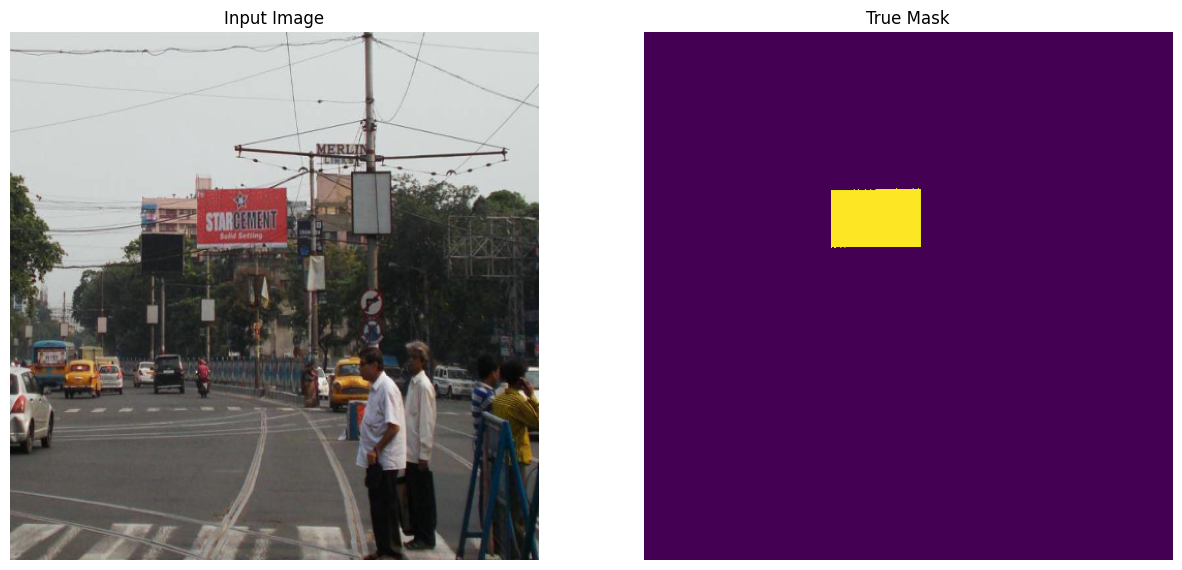

(512, 512, 3)


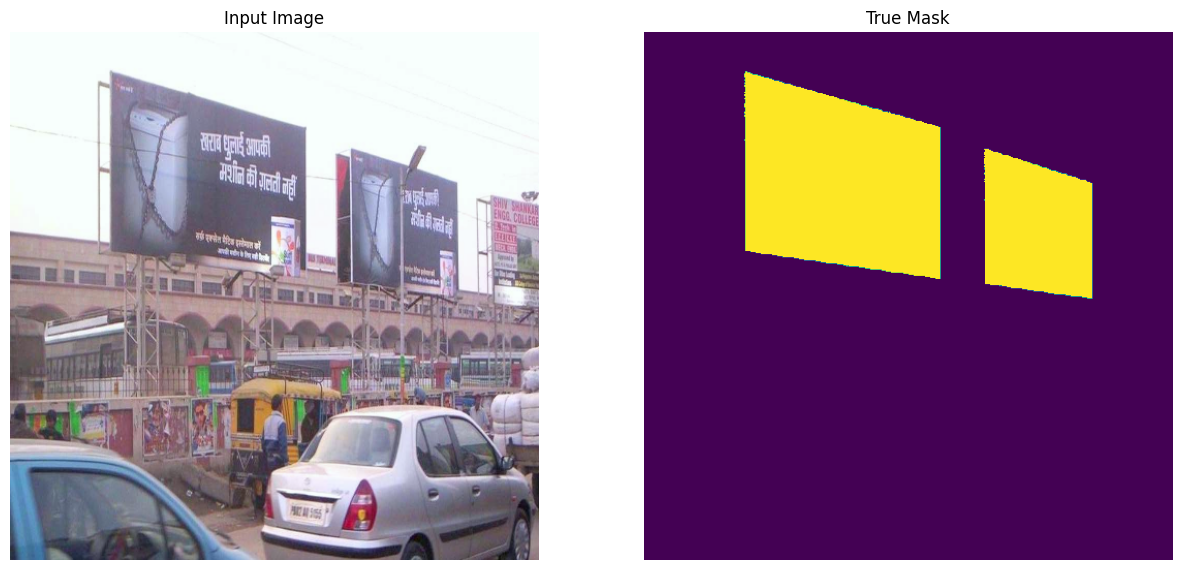

(512, 512, 3)


In [19]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()


for samples in train_ds.take(3):
    sample_image, sample_mask = samples["pixel_values"][0], samples["labels"][0]
    sample_image = tf.transpose(sample_image, (1, 2, 0))
    sample_mask = tf.expand_dims(sample_mask, -1)
    display([sample_image, sample_mask])
    print(sample_image.shape)

# Model

In [257]:
from transformers import TFSegformerForSemanticSegmentation

model_checkpoint = "mit-b5"
id2label =  {0: "unknown", 1: "billboard"}

label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)

model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

from IPython.display import clear_output
clear_output()

# Hyperparameters and compiling the model

In [21]:
lr = 0.00006
epochs = 200
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer)

In [22]:
model.summary()

Model: "tf_segformer_for_semantic_segmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segformer (TFSegformerMainL  multiple                 81443008  
 ayer)                                                           
                                                                 
 decode_head (TFSegformerDec  multiple                 3153410   
 odeHead)                                                        
                                                                 
Total params: 84,596,418
Trainable params: 84,594,882
Non-trainable params: 1,536
_________________________________________________________________


# Callback to visualize image after every epoch

In [23]:
from IPython.display import clear_output
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=1)
    pred_mask = tf.expand_dims(pred_mask, -1)
    return pred_mask[0]

In [24]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for sample in dataset.take(num):
            images, masks = sample["pixel_values"], sample["labels"]
            masks = tf.expand_dims(masks, -1)
            pred_masks = model.predict(images).logits
            images = tf.transpose(images, (0, 2, 3, 1))
            display([images[0], masks[0], create_mask(pred_masks)])
    else:
        display(
            [
                sample_image,
                sample_mask,
                create_mask(model.predict(tf.expand_dims(sample_image, 0))),
            ]
        )

In [25]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, **kwargs):
        super().__init__(**kwargs)
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(self.dataset)
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))


# Training Loop

1/1 [==============================] - 0s 212ms/step


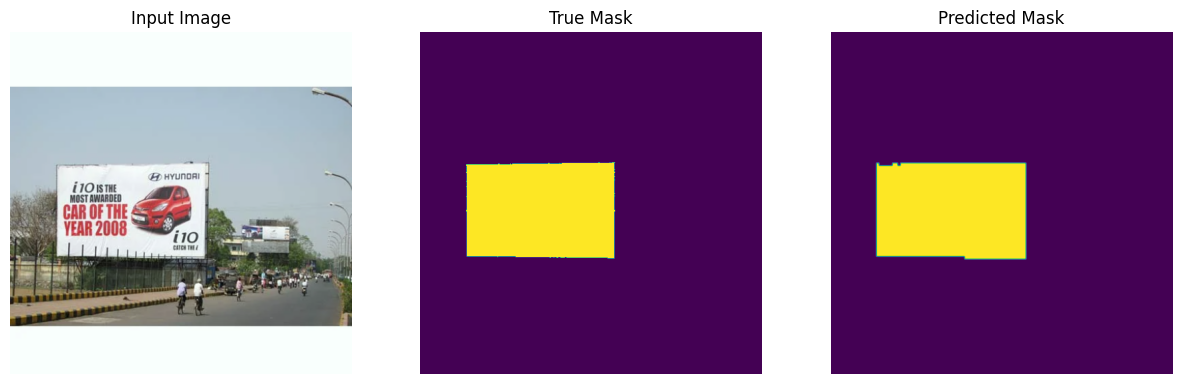


Sample Prediction after epoch 200

75/75 [==============================] - 45s 597ms/step - loss: 0.0017 - val_loss: 0.0052


In [26]:
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    callbacks=[DisplayCallback(valid_ds)],
    epochs=epochs,
)

<ipython-input-33-2df983d90a25>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


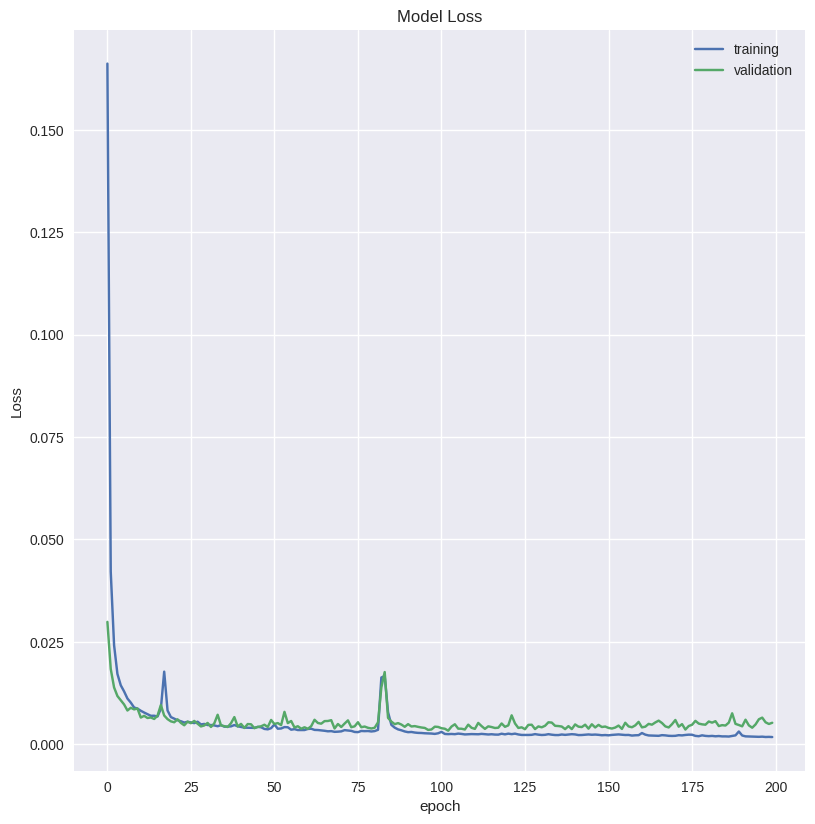

In [33]:
plt.style.use("seaborn")

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('Model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(8,8))
plt.tight_layout()
display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss', 111)
plt.savefig("train_eval_plot_segformer-5-b1.jpg")

In [27]:
model.save_weights("Billboard Segmentation.h5")

1/1 [==============================] - 0s 224ms/step


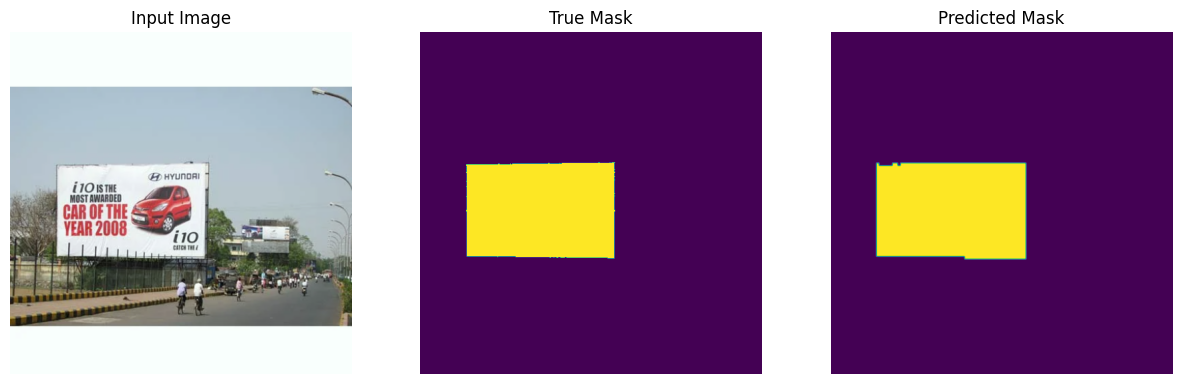

1/1 [==============================] - 0s 140ms/step


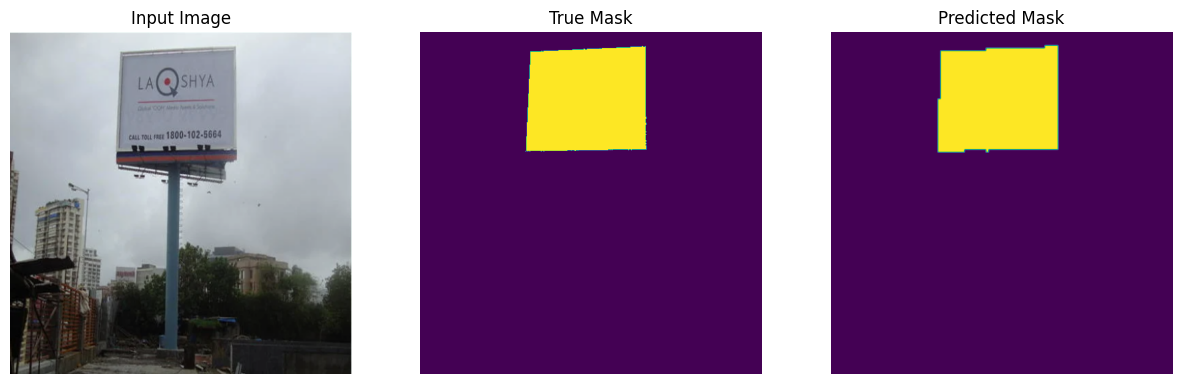

In [28]:
show_predictions(valid_ds, 23)

# Test Script

In [35]:
import tensorflow as tf
import numpy as np
from PIL import Image
from tensorflow.keras import backend
from transformers import TFSegformerForSemanticSegmentation

model_checkpoint = "mit-b5"
id2label = {0: "unknown", 1: "billboard"}

label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)

model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

model.load_weights("Billboard Segmentation.h5")

from IPython.display import clear_output
clear_output()
print("-"*23,"Model load Successfully","-"*23)

----------------------- Model load Successfully -----------------------


In [254]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()

def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=1)
    pred_mask = tf.expand_dims(pred_mask, -1)
    return pred_mask[0]

In [255]:
image = "Test/25.png"

image_size = 512
mean = tf.constant([0.485, 0.456, 0.406])
std = tf.constant([0.229, 0.224, 0.225])

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)

    input_image = tf.image.convert_image_dtype(image, tf.float32)
    input_image = tf.image.resize(input_image, (image_size, image_size))
    input_image = (input_image - mean) / tf.maximum(std, tf.keras.backend.epsilon())
    input_image = tf.transpose(input_image, (2, 0, 1))

    return {"pixel_values": input_image}

# test_image = preprocess_image(image)

1/1 [==============================] - 0s 158ms/step


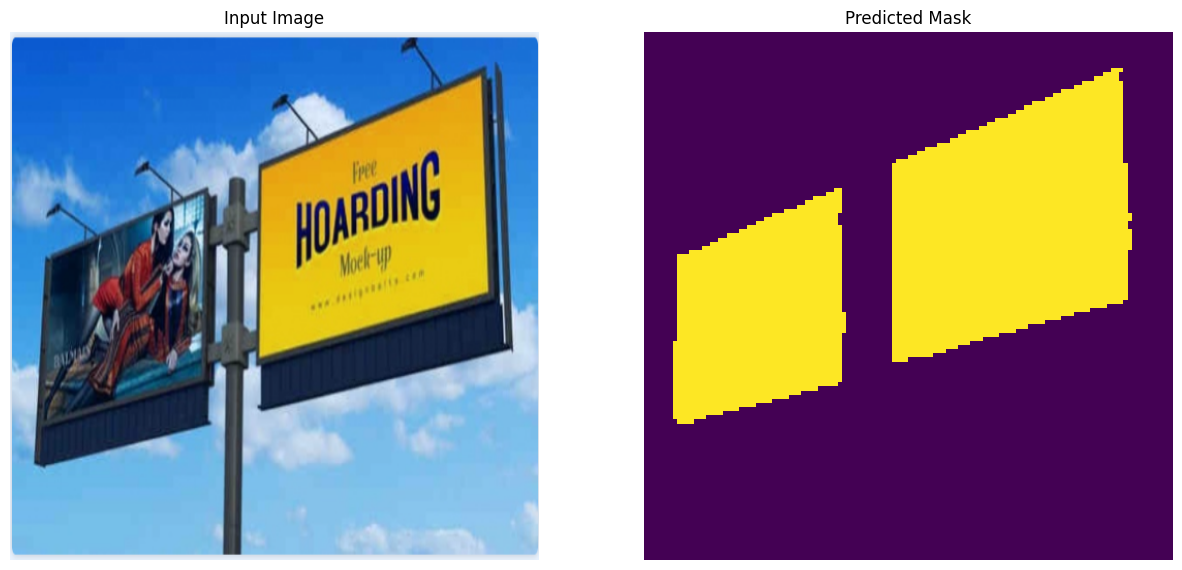

In [256]:
def generator_valid():
    yield {"pixel_values": tf.transpose(preprocess_image(image)["pixel_values"], (1, 2, 0))}  # Transpose the pixel_values to match the expected shape

auto = tf.data.AUTOTUNE
test_img = tf.data.Dataset.from_generator(generator_valid, output_signature={"pixel_values": tf.TensorSpec(shape=(512, 512, 3), dtype=tf.float32)}).batch(1)



def show_predictions(dataset=None, num=1):
    if dataset:
        for sample in dataset.take(num):
            images = tf.transpose(sample["pixel_values"], (0, 3, 1, 2))  # Adjust the dimensions
            pred_masks = model.predict(images).logits
            images = tf.transpose(images, (0, 2, 3, 1))
            display([images[0], create_mask(pred_masks)])
            save_predicted_mask(pred_masks)
    else:
        display(
            [
                sample_image,
                create_mask(model.predict(tf.expand_dims(sample_image, 0))),
            ]
        )


import numpy as np
import cv2

def save_predicted_mask(mask):
    # Assuming `mask` is a tensor representing the predicted mask
    mask = tf.reduce_max(mask, axis=0)  # Convert multichannel mask to a single channel

    # Threshold the mask to create a binary mask
    mask = tf.where(mask >= 0.5, 255, 0)  # Adjust the threshold as needed

    i, single_mask = mask
     # Convert the mask to a NumPy array
    single_mask_np = np.array(single_mask)

    # Resize the mask to 512x512
    single_mask_resized = cv2.resize(single_mask_np, (512, 512), interpolation=cv2.INTER_NEAREST)

    # Save the mask image to a file
    cv2.imwrite(f"predicted_mask.png", single_mask_resized)

show_predictions(test_img, 3)
